In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ephem 
from simons_array_python.calibration.planet import ephem_planet
from simons_array_python import sa_ephem as sa_ephem
import toast.qarray as qa
from simons_array_python import sa_sql
from toast.tod.sim_focalplane import cartesian_to_quat

INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_runid_g3.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_data_quality.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_mapping.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_monitor.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_template.db attached.
INFO: sqlite database /data/pb2/ChileData/databases/pb2a-20211207_benchmark_dataset/pb2a_stim_iq.db attached.


In [2]:
#Load the boresight quaternions in celestial coordinates, along with the times and telescope Az/El timestreams
det = '13.13_175.90B'
boresight_quat = np.load('boresight.npy')
times = np.load('bolo_time.npy')
az = np.load('az.npy')
el = np.load('/el.npy')

In [3]:
#Convert Az/El to RA/dec using ephem
def azel_to_radecpa(mjd, az, el):
        observer = sa_ephem.pb2a_site()
        ra, dec, pa = [], [], []
        for t, a, e in zip(mjd, az, el):
            observer.date = sa_ephem.mjd_to_ephem_date(t)
            r, d = observer.radec_of(a, e)
            obj = ephem.FixedBody()
            obj._ra, obj._dec = r, d
            obj.compute(observer)
            ra.append(r)
            dec.append(d)
            pa.append(-obj.parallactic_angle())
        return np.array(ra), np.array(dec), np.array(pa)

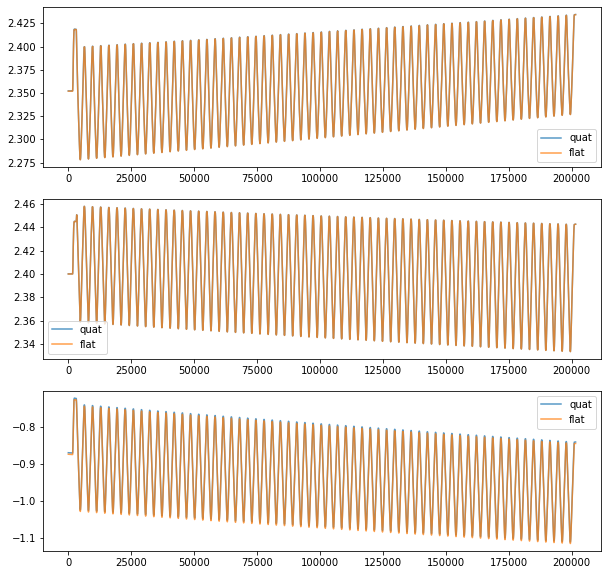

In [4]:
#First make sure the boresight_quats themselves agree with ephem
ra_boresight, dec_boresight, pa_boresight = azel_to_radecpa(times, az , el) 
theta_boresight, phi_boresight, pos_boresight = qa.to_angles(boresight_quat)

fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi_boresight, label='quat', alpha=0.75)
axes[0].plot(ra_boresight, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta_boresight, label='quat', alpha=0.75)
axes[1].plot(np.pi/2 - dec_boresight, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos_boresight, label='quat', alpha=0.75)
axes[2].plot(pa_boresight, label='flat', alpha=0.75)
axes[2].legend()

#Close enough?

In [5]:
#Load the detector offsets from the database
det_offset_x = np.deg2rad(sa_sql.db_impl.focalplane_db[det].det_offset_x)
det_offset_y = np.deg2rad(sa_sql.db_impl.focalplane_db[det].det_offset_y)
print(det_offset_x, det_offset_y)

#Manually apply the detector offsets in Az/El, then convert to RA/dec
ra, dec, pa = azel_to_radecpa(times, az-(det_offset_x/np.median(np.cos(el))) , el-det_offset_y) 

Reading SQL table pb2a_focalplane...done.
-0.003450062145587271 -0.003906919530589307


In [6]:
#Get the detector pointing from quaternions
det_offset_quat = cartesian_to_quat([[-np.rad2deg(det_offset_x), -np.rad2deg(det_offset_y), 0]])[0]
det_pntg = qa.mult(det_offset_quat, boresight_quat)

#Decompose detector pntg back into angles for comparison
theta, phi, pos = qa.to_angles(det_pntg)

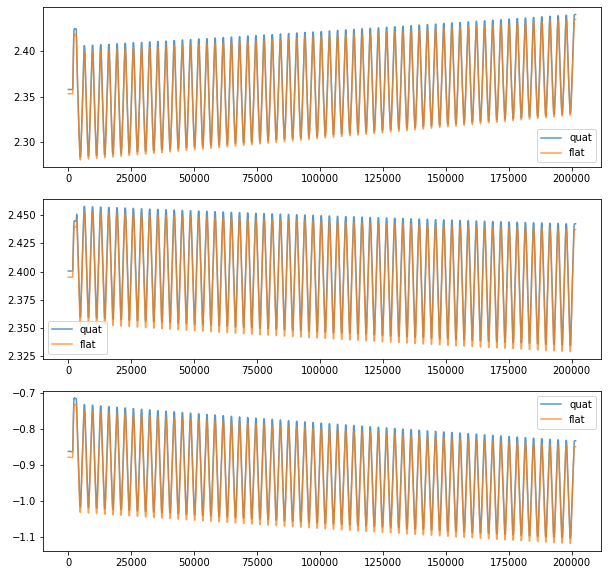

In [7]:
#Plot phi with RA, dec with theta, etc
fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi, label='quat', alpha=0.75)
axes[0].plot(ra, label='flat', alpha=0.75)
axes[0].legend()

axes[1].plot(theta, label='quat', alpha=0.75)
axes[1].plot(np.pi/2 - dec, label='flat', alpha=0.75)
axes[1].legend()

axes[2].plot(pos, label='quat', alpha=0.75)
axes[2].plot(pa, label='flat', alpha=0.75)
axes[2].legend()


In [8]:
#Errors in degrees:
print(
    np.rad2deg(np.mean(phi) - np.mean(ra)),
    np.rad2deg(np.mean(theta) - np.mean(np.pi/2 - dec)),
    np.rad2deg(np.mean(pos) - np.mean(pa))
)

0.25154992045601327 0.3127010611971028 0.9074046024388075


In [ ]:
#Difference plots
fig, axes = plt.subplots(3, figsize=(10,10))

axes[0].plot(phi-ra, label='phi-ra')
axes[0].legend()

axes[1].plot(theta-(np.pi/2-dec), label='theta-(np.pi/2-dec)')
axes[1].legend()

axes[2].plot(pos-pa, label='pos-')
axes[2].legend()